# Scaling Laws

Scaling laws refer to the relationship between a deep learning model's performance and its training inputs, such as its parameters, training data, and compute.

**Power Laws**

In the context of deep learning, scaling laws usually take the form of a power law $loss = \frac{\alpha_0}{p^\alpha}$, where p is some training parameter, such as dataset size, and $\alpha$ is a constant. 

One motivation for why scaling laws take the form of a power law is *scale invariance*, the idea that scaling x by a factor k produces the response in y $f(k)$ at any magnitude of x. This necessarily leads to the relationship of the form $y = cx^k$.

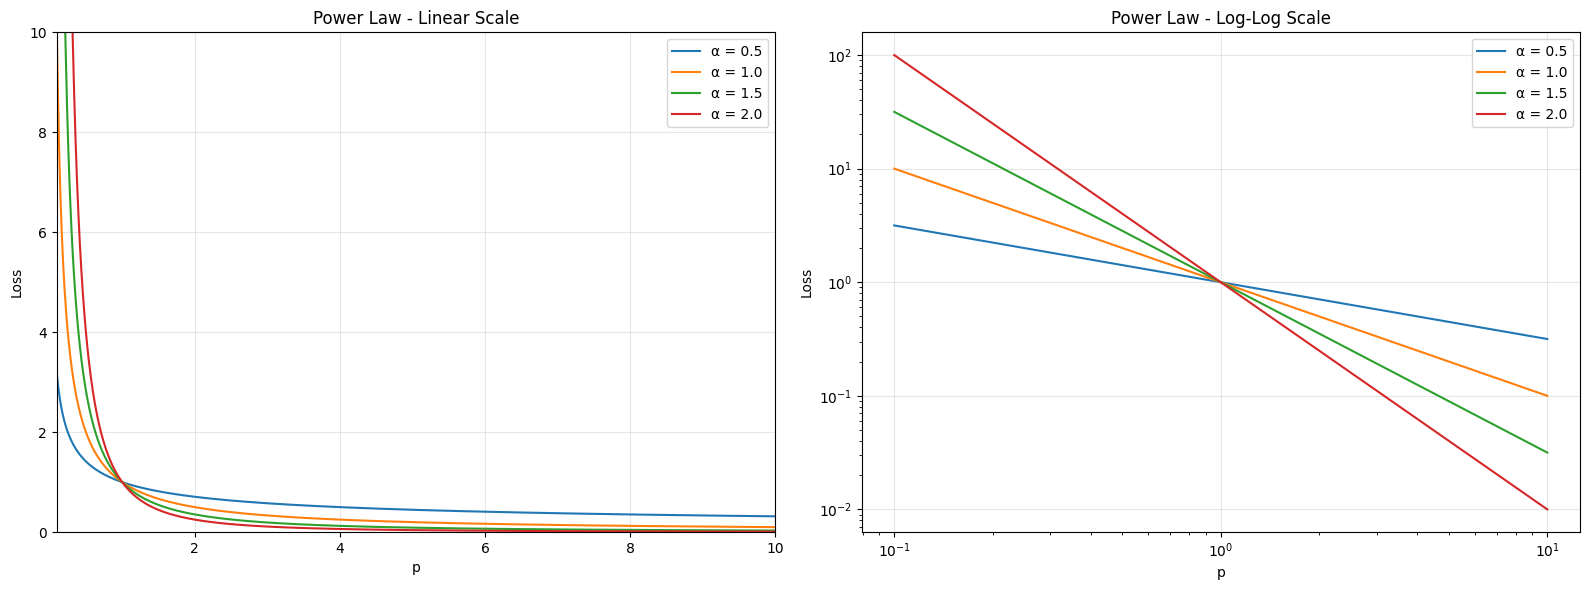

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Define the range of p values
p = np.linspace(0.1, 10, 1000)

# Define different alpha values
alphas = [0.5, 1.0, 1.5, 2.0]

# Create subplots for both linear and log-log scales
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), dpi=100)

# Linear scale plot
for alpha in alphas:
    y = 1 / (p ** alpha)
    ax1.plot(p, y, label=f'α = {alpha}')

ax1.set_xlabel('p')
ax1.set_ylabel('Loss')
ax1.set_title('Power Law - Linear Scale')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0.1, 10)
ax1.set_ylim(0, 10)

# Log-log scale plot
for alpha in alphas:
    y = 1 / (p ** alpha)
    ax2.loglog(p, y, label=f'α = {alpha}')

ax2.set_xlabel('p')
ax2.set_ylabel('Loss')
ax2.set_title('Power Law - Log-Log Scale')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Scaling laws are often visualized on log-log plots, where they are linear. 

Taking the logarithm of both sides of $loss = \frac{\alpha_0}{p^\alpha}$:

$\log(loss) = \log\left(\frac{\alpha_0}{p^\alpha}\right) = c_0 - \alpha \log(p)$

Note that steeper slopes indicate performance improves more quickly given an increase in the independent variable.

**Scaling Laws in Deep Learning**

Scaling laws are observed to occur between model performance and a variety of inputs, such as dataset size, number of parameters, and compute. Performance monotonically increases with these inputs, and they are usually characterized by power laws.

For example, the famous Kaplan (https://arxiv.org/pdf/2001.08361) paper shows clear power-law relationships between performance and compute, dataset size, and parameters.

# <img src="KaplanScalingLaws.png" style="width: 100%;">


The robustness of these scaling laws across many different orders of magnitude was one of the main reasons OpenAI restructured and invested massively in compute at unprecedented levels from 2018-2022; they extrapolated the power laws and deduced more compute was necessary (https://openai.com/index/ai-and-compute/?utm_source=chatgpt.com, https://openai.com/index/ai-and-compute/?utm_source=chatgpt.com). 

However, this power-law relationship does not hold forever; it has three characteristic regimes.

# <img src="3regime.png" style="width: 50%;">


Only in certain regions of the error vs. input plot does the power-law relationship hold. Eventually, the power-law relationship will break down. 

It is important to note that dataset size and model parameters, while independent levers, simultaneously affect the lower bound of model performance. At a fixed dataset size, the performance vs. parameter power-law region is bounded, and vice-versa. In the figure above, it perhaps is more accurate the label the "irreducible error" line as the sum of the true irreducible error in the distribution of the data and the approximation induced by finite degrees of freedom (number of parameters). 

If we increase the number of parameters, then the power-law region is extended and the "irreducible error" region is lowered (analogous relationship for more data improving maximum performance achieved by varying number of parameters).

Kaplan demonstrates this exactly:

# <img src="datasetsize_parameters.png" style="width: 75%;">


In fact, loss is well described as a power-law function of both dataset size and number of parameters (https://arxiv.org/pdf/2108.07686): 

$Loss = d^{-\alpha} + p^{-\beta}$, where $d$ is the dataset size and $p$ is the number of parameters.

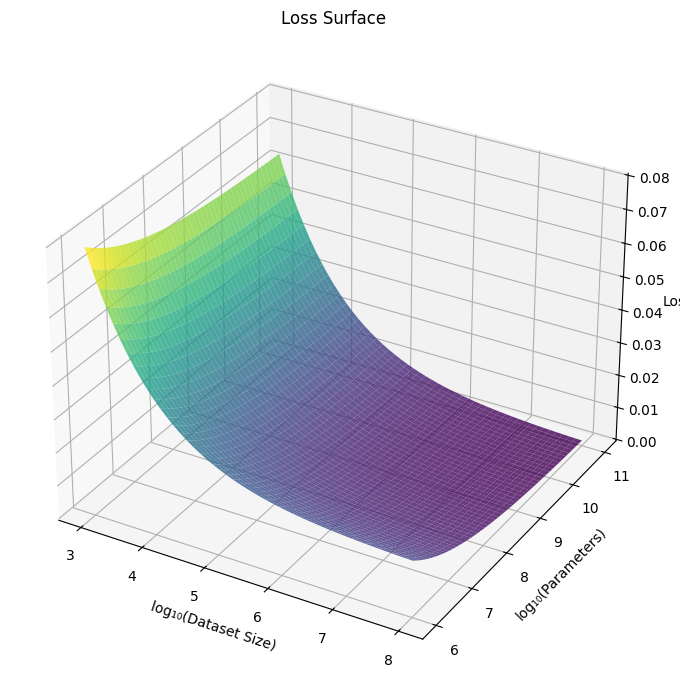

In [28]:
from mpl_toolkits.mplot3d import Axes3D

alpha = 0.4  
beta = 0.3   # Parameter scaling exponent

d = np.logspace(3, 8, 50)  # Dataset size from 10^3 to 10^8
p = np.logspace(6, 11, 50)  # Parameters from 10^6 to 10^11

D, P = np.meshgrid(d, p)

Loss = D**(-alpha) + P**(-beta)

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(np.log10(D), np.log10(P), Loss, 
                      cmap='viridis', alpha=0.8, edgecolor='none')

# Add labels and title
ax.set_xlabel('log₁₀(Dataset Size)')
ax.set_ylabel('log₁₀(Parameters)')
ax.set_zlabel('Loss')
ax.set_title('Loss Surface')

plt.tight_layout()
plt.show()


Given $Loss(P, D)$ and a compute budget $B = B(P, D)$ that acts as a constraint on P and D (assuming single-epoch), we can minimize the loss/maximize performance for the compute budget.

This is what the Chinchilla paper (https://arxiv.org/abs/2203.15556) determined quite successfully. They found that data and parameters should be scaled at the same rate - i.e. a doubling of parameter size should be coupled with a doubling in dataset size. Furthermore, they found the compute-optimal data-to-parameter ratio was ~20 tokens per parameter.

We have yet to define how "loss" and "performance" is measured. Scaling laws do not apply to any arbitrary loss function; they only hold for smooth, per-example loss functions (NLL or cross-entropy), the families of loss functions that are used to pre-train LLMs. 

Scaling laws do not hold for discrete/thresholded loss functions, a broader class of evals that we often reference nowadays, such as pass@k.

**Where Scaling Laws Stand Today**

Having covered the theoretical background of scaling laws, how are they being applied today and what do they tell us?

One interesting phenomenon is that frontier labs are training their models with vastly different parameter and dataset-size proportions than the compute-optimal allocation. Specifically, models are being "overtrained" on data, i.e. higher data-to-parameter ratios. Stanford reports:



<img src="tokens_param.png" style="width: 50%;">


This is because the "compute-optimal" allocation maximizes performance given a compute budget B(P, D). However, this does not include the budgetary costs from inference, which are more expensive with more parameters. 

By training on more tokens / parameter, labs are not reaching peak performance for their given training budget, but they are left with a more compute-efficient model during inference. Research from Epoch AI (https://epoch.ai/blog/will-we-run-out-of-data-limits-of-llm-scaling-based-on-human-generated-data) shows that under different economic assumptions, the optimal data allocation may be **100x the traditional "compute-efficient" allocation**.   

**Scaling Laws for Reasoning Models**

While mathematically different from the traditional scaling laws, which are power laws measured against smooth loss functions, a similar analysis applied to reasoning/test-time compute yields interesting takeaways.

# <img src="inference_scaling.png" style="width: 80%;">


These results are not formalized and somewhat anecdotal, but some results suggest that during inference, performance scales like $\log(I)$, where $I$ is the inference budget expended during inference. The competing takeaways are that scaling at inference time provides an immediate way to improve performance, but it quickly becomes uneconomical. 

**Are Scaling Laws Slowing Down?**

One common narrative is that "pre-training is {hitting a wall, slowing down}", an argument that used to imply scaling laws no longer hold. However, these claims are difficult to verify or refute. By construction, scaling laws imply incremental gains are exponentially harder to achieve. So, with compute growing at a non-exponential rate (GPT-5 actually used less compute than GPT-4.5), we will assuredly see a slower rate of progress than we were used to. 

So trivially, yes, pre-training is slowing down. 



The more interesting question is whether pre-training is in the power-law regime or irreducible error regime. Again, it's difficult to definitively say without concrete numbers from the frontier labs, and there isn't an accepted answer as to whether scaling laws are still holding. 

However, many researchers suggest that we may soon be bottlenecked by data; like we explored earlier, scaling parameters (and compute) only remains a power-law when data is scaled simultaneously. While compute availability is still growing, data is not growing meaningfully. Depending on the allocation of compute budget to data, projections (https://epoch.ai/blog/will-we-run-out-of-data-limits-of-llm-scaling-based-on-human-generated-data) suggest data will start bottlenecking scaling law relationships between 2025-2032. 

# <img src="data_budget.png" style="width: 80%;">


Note that in the scenario data becomes fixed, progress will not stop but scaling compute and parameters will not result in the same rate of improvement as predicted by traditional power laws. 